<a href="https://colab.research.google.com/github/asadali163/Computer-Vision-Projects/blob/main/codebase/CV_transfer_learning_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will use transfer learning to for binary classification task

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow

In [3]:
# Let's first unzip the homer_bart_2 dataset
!unzip homer_bart_2.zip

Archive:  homer_bart_2.zip
   creating: homer_bart_2/
  inflating: homer_bart_2/.DS_Store  
  inflating: __MACOSX/homer_bart_2/._.DS_Store  
   creating: homer_bart_2/training_set/
   creating: homer_bart_2/test_set/
  inflating: homer_bart_2/training_set/.DS_Store  
  inflating: __MACOSX/homer_bart_2/training_set/._.DS_Store  
   creating: homer_bart_2/training_set/homer/
   creating: homer_bart_2/training_set/bart/
  inflating: homer_bart_2/test_set/.DS_Store  
  inflating: __MACOSX/homer_bart_2/test_set/._.DS_Store  
   creating: homer_bart_2/test_set/homer/
   creating: homer_bart_2/test_set/bart/
  inflating: homer_bart_2/training_set/homer/homer38.bmp  
  inflating: homer_bart_2/training_set/homer/homer119.bmp  
  inflating: homer_bart_2/training_set/homer/homer124.bmp  
  inflating: homer_bart_2/training_set/homer/homer123.bmp  
  inflating: homer_bart_2/training_set/homer/.DS_Store  
  inflating: __MACOSX/homer_bart_2/training_set/homer/._.DS_Store  
  inflating: homer_bart_2/t

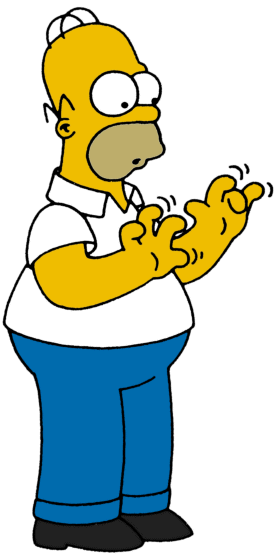

In [4]:
# Load one sample image for homer
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer100.bmp')

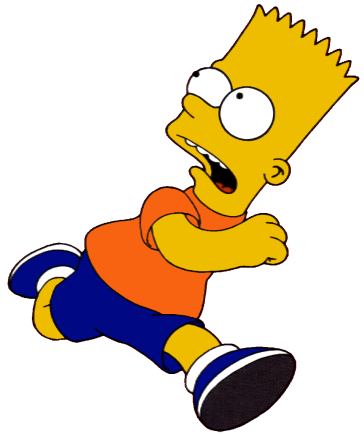

In [5]:
# Let's load sample image for bart
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')

Our Goal is to classify these images into their respective classes

In [38]:
# Lets define the train and test generator
train_generator = ImageDataGenerator(rescale=1./255,
                                     shear_range=0.2,
                                     horizontal_flip=True,
                                     rotation_range=10,
                                     zoom_range=0.2
                                     )

train_dataset = train_generator.flow_from_directory('/content/homer_bart_2/training_set',
                                                    batch_size=8,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(256,256)
                                                    )

Found 215 images belonging to 2 classes.


In [39]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [40]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [41]:
test_generator = ImageDataGenerator(rescale=1./255)

test_dataset = test_generator.flow_from_directory('/content/homer_bart_2/test_set',
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  target_size=(256,256)
                                                  )

Found 54 images belonging to 2 classes.


Let's load now the pre-trained ResNet50 model

In [42]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                             weights='imagenet',
                                             input_shape=(256,256,3)
                                             )

In [43]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [44]:
for layer in base_model.layers:
  layer.trainable = False

Now, Let's add our custom Dense Layer

In [45]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(1024, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(1024, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='sigmoid')(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

In [46]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,737,538 (102.00 MB)

 Trainable params: 3,149,826 (12.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
history = model.fit(train_dataset, epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - accuracy: 0.4934 - loss: 1.1688
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5824 - loss: 2.1748
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5010 - loss: 1.1124
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.5414 - loss: 0.8307
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.6392 - loss: 0.6808
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.5154 - loss: 0.7584
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6779 - loss: 0.6790
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.5963 - loss: 0.6639
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.6430 - loss: 0.6818
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6804 - loss: 0.6369
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.6551 - loss: 0.6593
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.63

Text(0.5, 1.0, 'Accuracy')

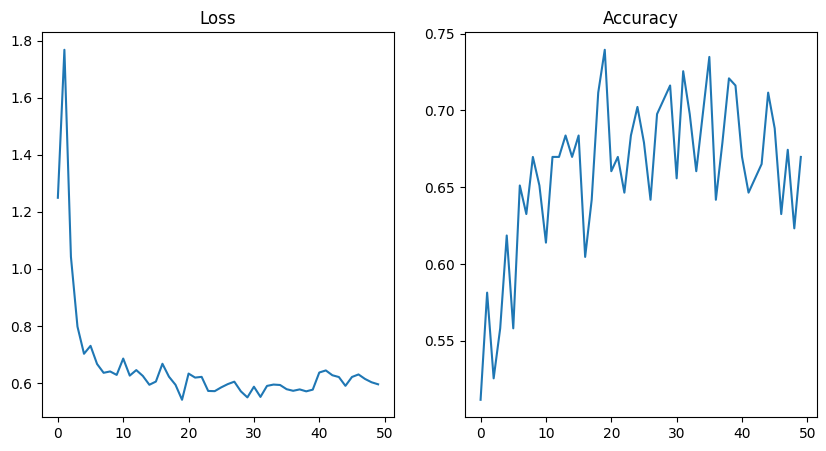

In [49]:
# Let's plot loss and accurayc graphs
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(history.history['loss'])
ax[0].set_title('Loss')
ax[1].plot(history.history['accuracy'])
ax[1].set_title('Accuracy')


As you can see the accuracy is somewhat between 60-67

In [50]:
# Let's predict
predictions = np.argmax(model.predict(test_dataset), axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [52]:
accuracy_score(test_dataset.classes, predictions)

0.7777777777777778

In [53]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

<Axes: >

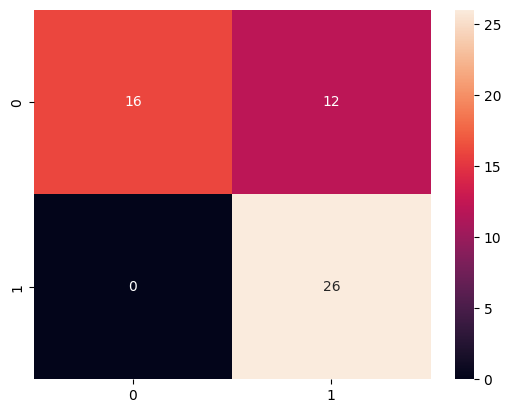

In [54]:
sns.heatmap(confusion_matrix(test_dataset.classes, predictions), annot=True)

In [56]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73        28
           1       0.68      1.00      0.81        26

    accuracy                           0.78        54
   macro avg       0.84      0.79      0.77        54
weighted avg       0.85      0.78      0.77        54



### As that was transfer-learning, let's apply fine-tuning to that

As the ResNet50 is trained on different dataset. So it is good idea to train the last few covolutional layers of neural network with a very small learning rate

In [57]:
len(base_model.layers)

175

As there is 175 layers, so we will train after 140

In [58]:
train_after = 140

In [59]:
base_model.trainable = True

for layer in base_model.layers[:train_after]:
  layer.trainable = False

In [60]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
history = model.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step - accuracy: 0.5826 - loss: 0.6370
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.6473 - loss: 0.6030
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5749 - loss: 0.6288
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6650 - loss: 0.5914
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.6432 - loss: 0.6067
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6255 - loss: 0.6313
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.6505 - loss: 0.5978 
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.6779 - loss: 0.5983
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7203 - loss: 0.5385
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.6841 - loss: 0.5797
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.7798 - loss: 0.5352 
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - a

In [62]:
# Now let's evaluate
predictions = np.argmax(model.predict(test_dataset), axis=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


In [63]:
accuracy_score(test_dataset.classes, predictions)

0.8518518518518519

As you can see the accuracy is imporved

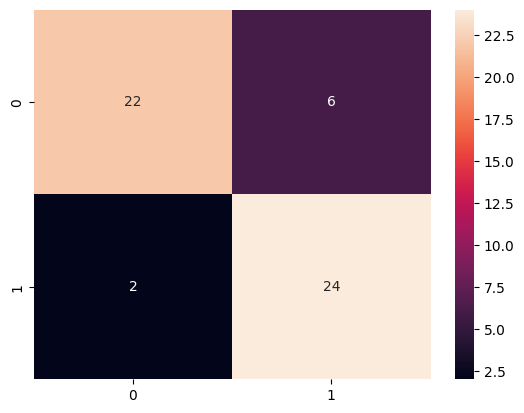

In [64]:
sns.heatmap(confusion_matrix(test_dataset.classes, predictions), annot=True);

In [66]:
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.80      0.92      0.86        26

    accuracy                           0.85        54
   macro avg       0.86      0.85      0.85        54
weighted avg       0.86      0.85      0.85        54



In [67]:
# Let's save and load the model
model.save('homer_bart.keras')

In [68]:
# Load the model
loaded_model = tf.keras.models.load_model('homer_bart.keras')

In [69]:
loaded_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 33,037,192 (126.03 MB)

 Trainable params: 3,149,826 (12.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 6,299,654 (24.03 MB)

In [70]:
accuracy_score(test_dataset.classes, np.argmax(loaded_model.predict(test_dataset), axis=1))

54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


0.8518518518518519

So that's all for this method